# Read Data

In [21]:
# Import Libraries and Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import scorecardpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("source data/twitter_human_bots_dataset.csv", index_col=0)
df.head()

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


# Data Cleaning

## Handling missing values

description, lang, location, profile_image_url and profile_background_image_url have missing values.

### Missing descriptions

As there are many bot accounts with missing description, this is a significant value, we would add a check for missing descriptions.

In [22]:
df.loc[df['description'].isnull(), 'account_type'].value_counts()
df['is_description_na'] = df['description'].isna().astype(int)
df.loc[df['description'].isnull(), 'description'] = ''

### Missing lang

As there are many bot accounts with missing lang, this is a significant value, we would add a check for missing langs.

In [23]:
df.loc[df['lang'].isnull(), 'account_type'].value_counts()
df['is_lang_na'] = df['lang'].isna().astype(int)
df.loc[df['lang'].isnull(), 'lang'] = ''

### Missing location

We set the missing locations to 'unknown' as that is already a value in the feature.

In [24]:
df.loc[df['location'].isnull(), 'account_type'].value_counts()
df.loc[df['location'].isnull(), 'location'] = 'unknown'

### Missing profile_background_image_url

We set the missing profile_background_image_url to the default url.

In [25]:
df.loc[df['profile_background_image_url'].isnull(), 'account_type'].value_counts()
default_background = df['profile_background_image_url'].mode()[0]
df.loc[df['profile_background_image_url'].isnull(), 'profile_background_image_url'] = default_background

### Missing profile_image_url

We set the missing profile_image_url to the default url.

In [26]:
df.loc[df['profile_image_url'].isnull(), 'account_type'].value_counts()
default_image = df['profile_image_url'].mode()[0]
df.loc[df['profile_image_url'].isnull(), 'profile_image_url'] = default_image

In [27]:
print(df.isnull().sum())    

created_at                      0
default_profile                 0
default_profile_image           0
description                     0
favourites_count                0
followers_count                 0
friends_count                   0
geo_enabled                     0
id                              0
lang                            0
location                        0
profile_background_image_url    0
profile_image_url               0
screen_name                     0
statuses_count                  0
verified                        0
average_tweets_per_day          0
account_age_days                0
account_type                    0
is_description_na               0
is_lang_na                      0
dtype: int64


# Feature Engineering
* Feature Creation
* Feature Reduction (using Weight of Evidence(woe) check for feature importance, Correlation)
* Run feature selection using tree base algo (random forest or smth)

## Encoding categorical variables

### Encoding boolean features into 0 and 1s

In [28]:
df['account_type_map'] = df['account_type'].map({'bot': 1, 'human': 0})

df['default_profile'] = df['default_profile'].astype(int)
df['default_profile_image'] = df['default_profile_image'].astype(int)
df['verified'] = df['verified'].astype(int)
df['geo_enabled'] = df['geo_enabled'].astype(int)


### Encoding common values for lang and location

In [29]:
df['is_lang_en'] = df['lang'].map({'en': 1}).fillna(0)
print(df['is_lang_en'].value_counts())  

is_lang_en
1.0    21450
0.0    15988
Name: count, dtype: int64


### Encoding unknown values for location

In [30]:
df['is_location_unknown'] = df['location'].map({'unknown': 1}).fillna(0)
print(df['is_location_unknown'].value_counts())

is_location_unknown
0.0    24411
1.0    13027
Name: count, dtype: int64


## Transformed Features to consider:
* Sentiment analysis for description
* Number of mentions in description to other bot accounts
* Influencer Type 
* Length of description
* Favorite Activity Level for each user
* Ratio Followers_count to friends count
* Ratio of Followers_count to tweets per day
* Ratio of friends to tweets per day
* Ratio of tweets since account created
* Time when account was created (Past midnight of timezone, obtained from location)
* Standard deviation of avg tweets from avg tweets of bots

<b>Total Features: 18 (provided) + 9 (created)</b>

In [31]:
df['created_at'] = pd.to_datetime(df['created_at'])

current_time = datetime.now()
df['account_age_days'] = (current_time - df['created_at']).dt.days

df['creation_hour'] = df['created_at'].dt.hour

df['creation_day_of_week'] = df['created_at'].dt.dayofweek

df['creation_month'] = df['created_at'].dt.month

df['creation_year'] = df['created_at'].dt.year

df['is_weekend'] = df['created_at'].dt.dayofweek >= 5

df['creation_quarter'] = df['created_at'].dt.quarter

def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['part_of_day'] = df['creation_hour'].apply(part_of_day)

df['creation_week_of_year'] = df['created_at'].dt.isocalendar().week

df['is_beginning_of_month'] = df['created_at'].dt.day <= 5
df['is_end_of_month'] = df['created_at'].dt.day >= 26

tmp_lst = ['account_age_days','creation_hour','creation_day_of_week','creation_month','creation_year','creation_quarter']
tmp_lst_cat = ['is_weekend','part_of_day','is_beginning_of_month','is_end_of_month']
df[tmp_lst].describe()
df[tmp_lst_cat].value_counts()


is_weekend  part_of_day  is_beginning_of_month  is_end_of_month
False       Night        False                  False              7102
            Afternoon    False                  False              4030
            Evening      False                  False              3970
            Morning      False                  False              3311
True        Night        False                  False              2255
False       Night        False                  True               1830
                         True                   False              1707
True        Afternoon    False                  False              1282
            Evening      False                  False              1270
            Morning      False                  False              1205
False       Evening      False                  True               1082
                         True                   False              1058
            Afternoon    False                  True               1032


#### Deviation from humans average tweets per day

This has to be processed after train test split.

In [32]:
humans_mean = df[df['account_type'] == 'human']['average_tweets_per_day'].mean()
humans_std = df[df['account_type'] == 'human']['average_tweets_per_day'].std()

df['deviation_from_humans'] = df['average_tweets_per_day'].apply(
    lambda x: (x - humans_mean) / humans_std
)

df['deviation_from_humans'].describe()

count    37438.000000
mean         0.012280
std          1.685264
min         -0.460227
25%         -0.426289
50%         -0.358206
75%         -0.081216
max         86.548835
Name: deviation_from_humans, dtype: float64

#### Length of Description Feature

In [33]:
df['description_length'] = df['description'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
print(df['description_length'].describe())
print(df['description_length'].isna().sum())

count    37438.000000
mean        67.017202
std         55.217549
min          0.000000
25%         14.000000
50%         58.000000
75%        118.000000
max        191.000000
Name: description_length, dtype: float64
0


#### Ratio of followers_count to friends_count per day

In [34]:
df['friends_count'].describe()

count    3.743800e+04
mean     4.445925e+03
std      4.954520e+04
min      0.000000e+00
25%      3.700000e+01
50%      2.960000e+02
75%      8.930000e+02
max      4.343060e+06
Name: friends_count, dtype: float64

##### Checking for zero friends

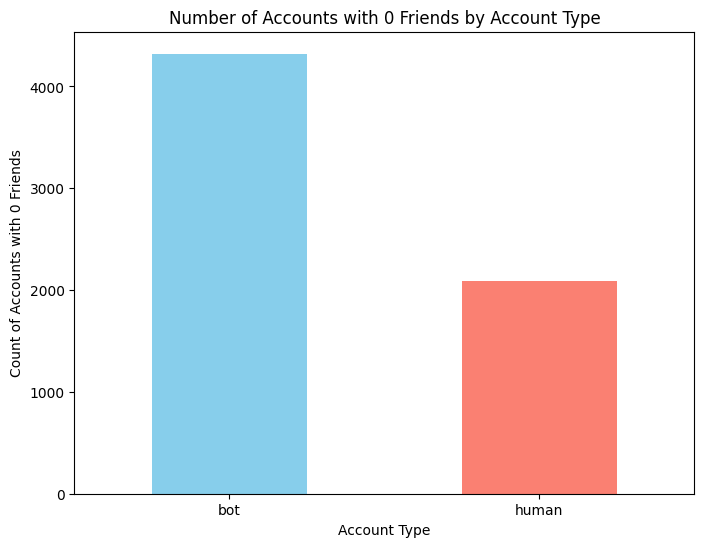

In [35]:
# Filter accounts with 0 friends
zero_friends_df = df[df['friends_count'] == 0]

# Group by account type and count
account_type_counts = zero_friends_df['account_type'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
account_type_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Number of Accounts with 0 Friends by Account Type")
plt.xlabel("Account Type")
plt.ylabel("Count of Accounts with 0 Friends")
plt.xticks(rotation=0)
plt.show()

##### Checking for zero followers

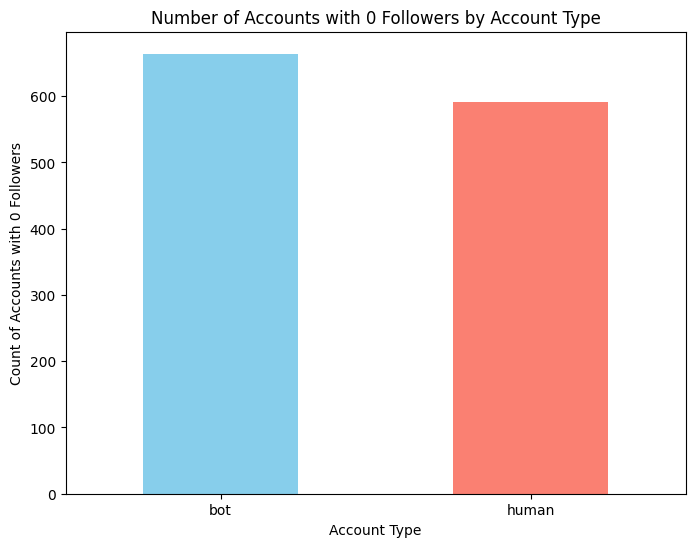

In [36]:
# Filter accounts with exactly 0 followers
nine_followers_df = df[df['followers_count'] == 0]

# Group by account type and count
account_type_counts = nine_followers_df['account_type'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
account_type_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Number of Accounts with 0 Followers by Account Type")
plt.xlabel("Account Type")
plt.ylabel("Count of Accounts with 0 Followers")
plt.xticks(rotation=0)
plt.show()

##### Handling outliers

In [ ]:
# Get ratio
df['followers_to_friends_ratio'] = df.apply(
    lambda row: row['followers_count'] / row['friends_count'] if row['friends_count'] != 0 else np.nan, axis=1
)

ratio_95th_percentile = df['followers_to_friends_ratio'].quantile(0.95)
# Cap the ratio at the 95th percentile
df['followers_to_friends_ratio'] = df['followers_to_friends_ratio'].apply(
    lambda x: min(x, ratio_95th_percentile) if not np.isnan(x) else x
)


df['followers_to_friends_ratio'].describe()

count    31028.000000
mean       628.178169
std       1812.745244
min          0.000000
25%          0.420908
50%          1.153846
75%         20.509693
max       7428.411956
Name: followers_to_friends_ratio, dtype: float64

#### Ratio of Followers_count to tweets per day

How to deal with np.nan?

In [38]:
# Calculate the followers_to_tweets_per_day_ratio safely
df['followers_to_tweets_per_day_ratio'] = df.apply(
    lambda row: row['followers_count'] / row['average_tweets_per_day'] if row['average_tweets_per_day'] != 0 else np.nan, axis=1
)

# Display the descriptive statistics
print(df['followers_to_tweets_per_day_ratio'].describe())

count    3.736600e+04
mean     9.347514e+05
std      5.343415e+07
min      0.000000e+00
25%      4.645132e+01
50%      2.161178e+02
75%      2.747765e+03
max      7.379663e+09
Name: followers_to_tweets_per_day_ratio, dtype: float64


#### Ratio of friends to tweets per day

In [39]:
df['friends_to_tweets_per_day_ratio'] = df.apply(
    lambda row: row['friends_count'] / row['average_tweets_per_day'] if row['average_tweets_per_day'] != 0 else np.nan, axis=1
)

print(df['friends_to_tweets_per_day_ratio'].describe())

count    3.736600e+04
mean     6.286888e+03
std      5.903397e+05
min      0.000000e+00
25%      1.916921e+01
50%      1.247851e+02
75%      4.629799e+02
max      1.127823e+08
Name: friends_to_tweets_per_day_ratio, dtype: float64


#### Extracting mentions count

In [40]:
def extract_mentions(description):
    mentions = re.findall(r'@\w+', str(description))
    return mentions

# Apply the function to the description column to create a new column with the mentions
df['mentions'] = df['description'].apply(extract_mentions)

# Feature: Count of mentions
df['mention_count'] = df['mentions'].apply(len)

# Display the dataframe with the new columns
print(df[['description', 'mentions', 'mention_count' ]].head())


                                         description  \
0  Blame @xaiax, Inspired by @MakingInvisible, us...   
1  Photographing the American West since 1980. I ...   
2  Scruffy looking nerf herder and @twitch broadc...   
3  Wife.Godmother.Friend.Feline Fanatic! Assistan...   
4               Loan coach at @mancity & Aspiring DJ   

                     mentions  mention_count  
0  [@xaiax, @MakingInvisible]              2  
1                          []              0  
2           [@twitch, @gmail]              2  
3                          []              0  
4                  [@mancity]              1  


In [41]:
# Count null values in each column
null_followers_to_friends_ratio = df['followers_to_friends_ratio'].isnull().sum()
null_followers_to_tweets_per_day_ratio = df['followers_to_tweets_per_day_ratio'].isnull().sum()
null_friends_to_tweets_per_day_ratio = df['friends_to_tweets_per_day_ratio'].isnull().sum()

# Display the counts
print("Null values in followers_to_friends_ratio:", null_followers_to_friends_ratio)
print("Null values in followers_to_tweets_per_day_ratio:", null_followers_to_tweets_per_day_ratio)
print("Null values in friends_to_tweets_per_day_ratio:", null_friends_to_tweets_per_day_ratio)


Null values in followers_to_friends_ratio: 6410
Null values in followers_to_tweets_per_day_ratio: 72
Null values in friends_to_tweets_per_day_ratio: 72


### Resolving NA in created features

In [42]:
df['followers_to_friends_ratio'].fillna(0, inplace=True)
df['followers_to_tweets_per_day_ratio'].fillna(0, inplace=True)
df['friends_to_tweets_per_day_ratio'].fillna(0, inplace=True)

## Sentiment Analysis for `description` feature

In [43]:

from transformers import pipeline

# Preprocess the description column
description = df['description'].fillna('').str.lower()
description = description.str.replace(r'@\w+', '', regex=True)
description = description.str.replace(r'http\S+', '', regex=True)
description = description.str.replace('#', '', regex=True)
description = description.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

# Get description statistics
print(len(description))
description_lengths = description.apply(len)
print(description_lengths.describe())
print(description)

# Initialise model
model_name = 'bert-base-uncased'
sentiment_model = pipeline('sentiment-analysis', model=model_name)

# Get sentiment of the description
sentiments = description.apply(lambda text: sentiment_model(text)[0])

df1 = pd.DataFrame(sentiments.tolist())
print(df1.head())
# Takes 25 minutes to run


37438
count    37438.000000
mean        54.568273
std         48.785776
min          0.000000
25%          7.000000
50%         43.000000
75%         96.000000
max        173.000000
Name: description, dtype: float64
0        blame  inspired by  using cmu phonetic data to...
1        photographing the american west since 1980 i s...
2        scruffy looking nerf herder and  broadcaster\r...
3        wifegodmotherfriendfeline fanatic assistant pr...
4                              loan coach at   aspiring dj
                               ...                        
37433    role stock taker past roles nanny sales assist...
37434                       kingdom landlord freecornbread
37435        bienvenid al twitter oficial de sergio dalma 
37436    just a good guy wrapped up in a bad system\r\n...
37437                                                     
Name: description, Length: 37438, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


     label     score
0  LABEL_0  0.512634
1  LABEL_0  0.599357
2  LABEL_0  0.566085
3  LABEL_0  0.537103
4  LABEL_1  0.516152


In [51]:
# Add sentiment label to original df
df['sentiment_label'] = df1['label'].map({'LABEL_0': 0, 'LABEL_1': 1})
# Label 0 = Negative, Label 1 = Positive

df.groupby('account_type')['sentiment_label'].value_counts()

account_type  sentiment_label
0             0                  18005
              1                   7008
1             0                   9150
              1                   3275
Name: count, dtype: int64

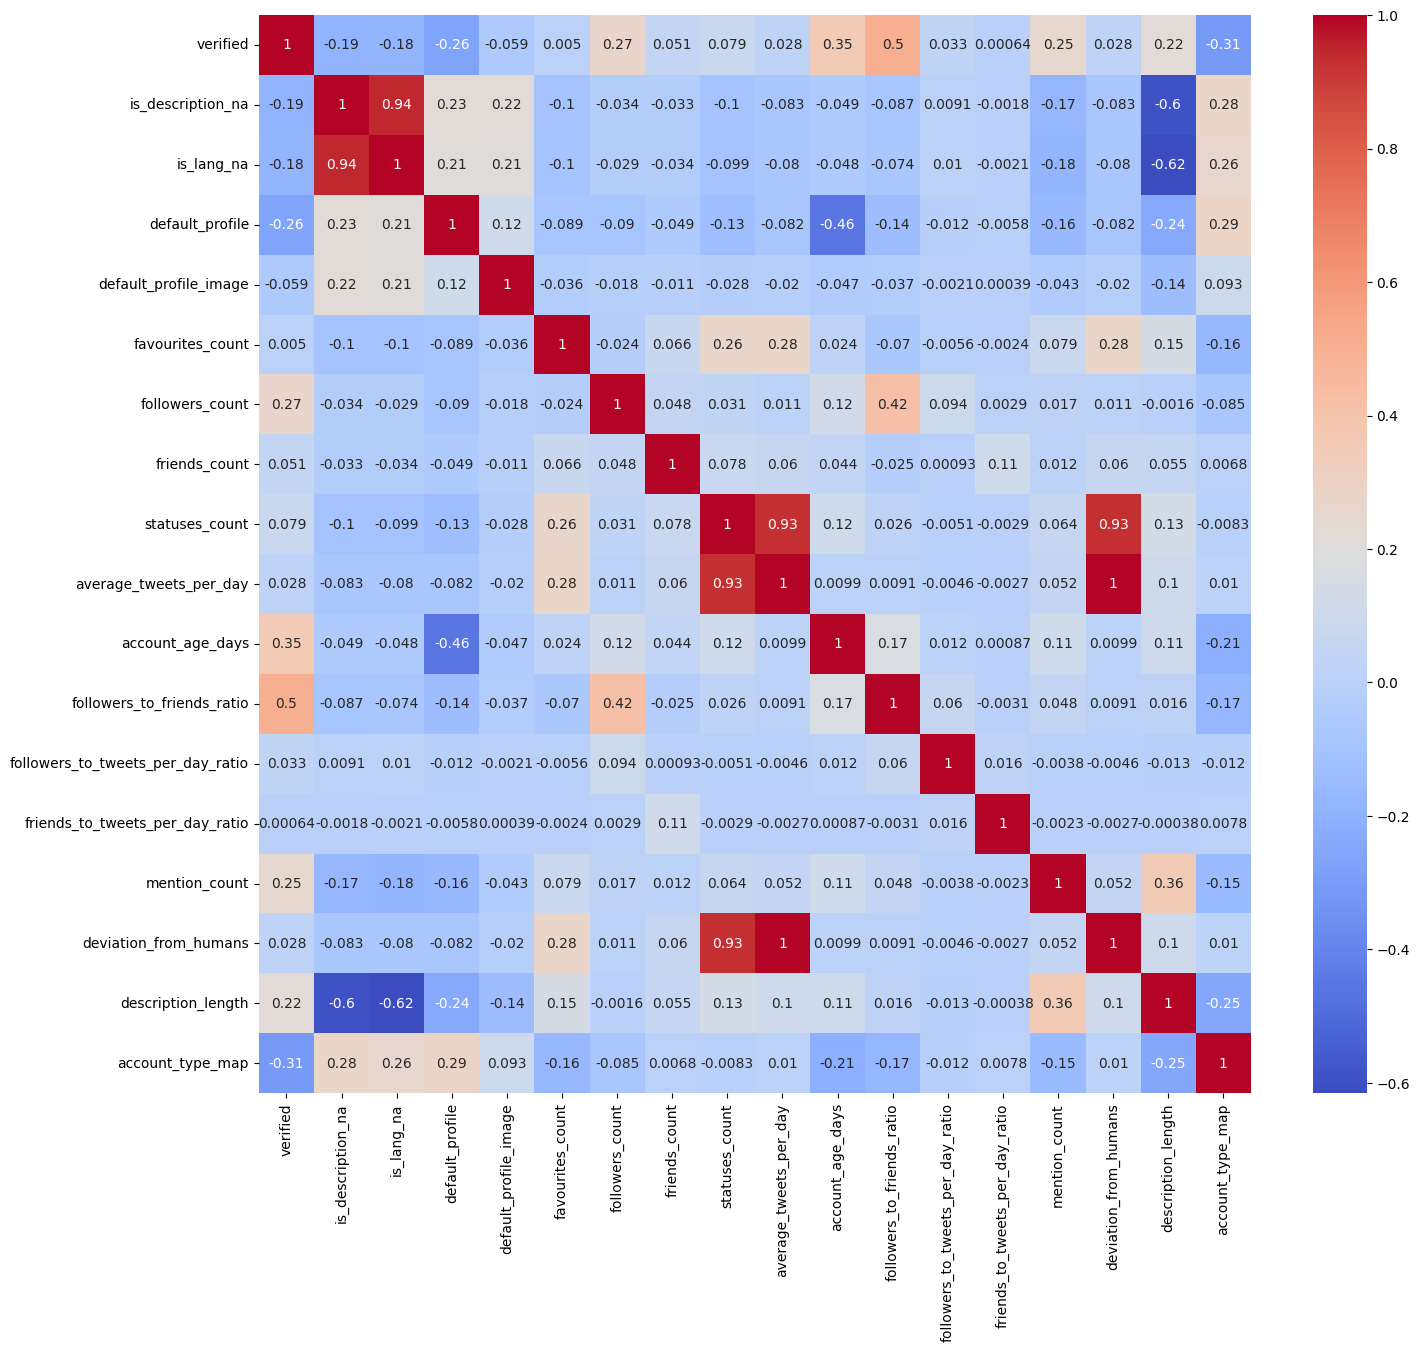

In [46]:

# Select numerical columns
numerical_columns = ['verified', 'is_description_na', 'is_lang_na', 'default_profile', 
                     'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 
                     'statuses_count', 'average_tweets_per_day', 'account_age_days', 
                     'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio', 'friends_to_tweets_per_day_ratio',
                     'mention_count', 'deviation_from_humans', 'description_length',
                     'account_type_map',]

# Calculate correlation matrix
correlation_matrix = df[numerical_columns].corr()
# Set the figure size
plt.figure(figsize=(16, 14))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

# Since statuses_count and average_tweets_per_day are highly correlated, we have to drop one of them
# As average_tweets_per_day has a higher correlation with the target variable, we will drop statuses_count

## Weight of Evidence

<strong>How WOE works:</strong>

Run the features you want to conduct weight of evidence on. For example, I put the features in temp_list and then created a dataframe containing only those features in df_tmp.

* Step 1: Replace temp_list with your features
* Step 2: Run code chunk below
* Step 3: Look at the WOE score for each bin of each feature to interpret WOE results

How to Interpret WOE scores
Negative or Positive Values indicate the direction of the feature while the magnitude indicate the strength of the feature.
E.g For the feature "statuses_count", if the woe score for one of its bin is 0.5 it indicates that for that bin, the feature "statuses_count" identifies many bots.
Conversely if the woe score for one of its bin is -0.7, it means that the feature is not good a predicting bots.

Also do look at the IV scores to determine the features contribution. Generally an IV of >0.02 indicates weak predictive power while >0.5 indicates strong predictive power.

In [47]:
temp_lst = ['favourites_count', 'followers_count','account_type','mention_count']

#Transforming Bot/Human to 1s and 0s
df['account_type'] = df['account_type'].replace({'bot': 1, 'human': 0})

y = df['account_type']  
X = df.drop(columns=['account_type'])  

df_tmp = df[temp_lst]
# Conduct the binning process using woebin
bins = sc.woebin(df_tmp, y='account_type', bins = 5)

# Display the binning information (optional to view WoE values per variable)
for key in bins.keys():
    print(f"Binning for {key}:")
    print(bins[key])


[INFO] creating woe binning ...
Binning for mention_count:
        variable         bin  count  count_distr   good    bad   badprob  \
0  mention_count  [-inf,1.0)  31088     0.830386  19724  11364  0.365543   
1  mention_count   [1.0,2.0)   3841     0.102596   3063    778  0.202551   
2  mention_count   [2.0,inf)   2509     0.067017   2226    283  0.112794   

        woe    bin_iv  total_iv breaks  is_special_values  
0  0.148299  0.018694  0.149074    1.0              False  
1 -0.670738  0.040137  0.149074    2.0              False  
2 -1.362830  0.090243  0.149074    inf              False  
Binning for followers_count:
          variable             bin  count  count_distr   good    bad  \
0  followers_count    [-inf,500.0)  20173     0.538838   9881  10292   
1  followers_count  [500.0,1500.0)   4511     0.120493   3685    826   
2  followers_count    [1500.0,inf)  12754     0.340670  11447   1307   

    badprob       woe    bin_iv  total_iv  breaks  is_special_values  
0  0.51